- Wind energy production/amount is a function of _wind speed_ and its _direction_.
 - forecast amount is sold to the grid operator
 - the grid operator fines if there's shortfall from forecast
 - excess is wasted
- Grid operator **(buys , 10 euro cents/kWh)**, enforces fines if there's a shortfall by the energy producer
- Spot market price for energy **(sells, 20 euro cents/kWh)**
- In case if we do not have anough cash to buy from the spot market, we pay a fine for the amount we failed to deliver **(penalty, 100 euro cents/kWh)**

__Objective__
- Our goal is to get a **T+18 hour energy forecast , every hour for entire Ile-de-France region**. Our objective, as a trader, is to maximize profits for our client using our energy production forecast and the given trading algorithm (this alg-m is fixed for simplicity).


In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
#hide
#For running in JupyterHub:
import os
if os.path.basename(os.getcwd())!='nbs':
    lib_path = os.path.expanduser(os.path.relpath('~/images/codesDIR/datathon2020/P003'))
    os.chdir(lib_path)

In [15]:
import os, pandas as pd, numpy as np
import datetime
from src import datautils

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (15,6)
%matplotlib inline

In [ ]:
# !ln -s ../src/ .

## Trade:
1. Produce a forecast
    - Excess is wasted (i.e. 0cents/kWh)
    - Shortfall is covered by trader (we need to buy this amount from spot market, _if we have cash in hand_ ):
        - buy 20cents/kWh
    - If there's no money to buy:
        - If _cash in hand_ is lower than required to purchase the shortfall amount
        - We are fined by grid 100cents/kWh
        - Recorded as a negative value (debt), and it's cumulative.
1. Starting budget 10,000,000 cents
1. Need to return 10,000,000 cents at the end of the evaluation period.
1. The remainder is our client's profits. Our objective is to maximise this profit.

## Datasets and Sources
Datasets:
1. Wind Energy Production \[src : Réseau de transport d'électricité [(RTE)](https://www.rte-france.com/), the French electricity transmission system operator\]
    - **We average and standardise to a time base of 1 hour** a near-realtime wind energy data from RTE's online database.
    - The dataset is called `energy-ile-de-france` (contains the consolidated energy wind production for the Ile-de-France region surrounding Paris)
2. Wind Forecasts \[src : [Terra Weather](http://www.terra-weather.com)\]
    - Provided are _wind forecasts for 8 locations_ of major wind farms in the Ile-de-France region.



### Wind Energy Production Data
- We use data __from 01 Jan 2017 to the present__. (download these)
- Real-time data are in Paris time.
- [`https://www.rte-france.com/en/eco2mix/eco2mix-telechargement-en`](https://www.rte-france.com/en/eco2mix/eco2mix-telechargement-en)
- The energy production (power) values are in __MW__ units (we need to convert them to kWh before trading! *i.e. get mean power over hour to get energy*).

---
Notes on Wind Energy Datasets:
1. **AI4Impact `energy-ile-de-france` Dataset**<br>
In autocaffe, the dataset is called `energy-ile-de-france`, and contains *standardised 1 hourly values* (UTC, in kWh).<br>
AI4Impact link for all years including latest readings (**all in UTC and kWh**):
    - 1/1/2017-*now*: `https://ai4impact.org/P003/historical/energy-ile-de-france.csv`
    - **to download it** use `datautils.download_energy_latest()` (from `/src/datautils.py`)
    - **to read** use `datautils.read_ai4impact_energy(...)`
    - AI4Impact is delayed compared to the raw RTE data.
1. **Raw Datasets from RTE**<br>
Following are for downloading regional energy production _raw data for Ile-de-France_ :
    - **for downloading** RTE data use `datautils.download_raw_from_RTE()` (in `/src/datautils.py`), for available urls see
    `datautils.wind_energy_urls`.
    - **to read** in kWh use `datautils.read_RTE_as_kwh(...,convert2UTC=True)` (in `/src/datautils.py`, set convert2UTC=True for real-time data).
    - For 2019_May2020 data ("Consolide" data) YOU WILL NEED TO REMOVE EXTRA COLUMNS (each row has different #col-s), before reading with pandas.
        - The current fixed version of this dataset (data for 01/01/2019-31/05/2020) is `./datasets/eCO2mix_RTE_Ile-de-France_En-cours-Consolide_FIXED_ERRCOLS.xls`
    - Regarding different datasets from RTE website, the "Current consolidated data" and "Current real-time data" could change which dates they contain depending on when you are downloading them. (*see disclaimer from RTE website below*):<br>
    >During the course of the following month, the indicators are consolidated to include available metering data. During the first six months of the following year, the indicators are finalized with the latest metering data and become definitive. 

---
**Total Nominal Power Outputs** of all wind farms in the Ile-de-France region (based on RTE website data):
- 01/01/2017 - 01/06/2017 : 43MW
- 01/06/2017 - 01/12/2017 : 55MW
- 01/12/2017 - 01/09/2019 : 70MW
- 01/09/2019 - now : 89MW (~89.8MW)<br>
The Difference network should be able to handle the changes above (nominal power— max. possible output, changes in time as newer and larger wind farms are built)


- **Download latest readings** (includes 1/1/2017-now)

#### Downloading and Reading AI4Impact Wind Energy Data

UTC time now: 2020-07-15 09:23:55

Downloaded from:
`https://ai4impact.org/P003/historical/energy-ile-de-france.csv`
saved to:
datasets/energy-ile-de-france.csv
                     Energy(kWh)
Datetime                        
2020-07-15 04:00:00      10000.0
2020-07-15 05:00:00       9500.0
2020-07-15 06:00:00      12250.0
2020-07-15 07:00:00      10750.0
2020-07-15 08:00:00       8000.0


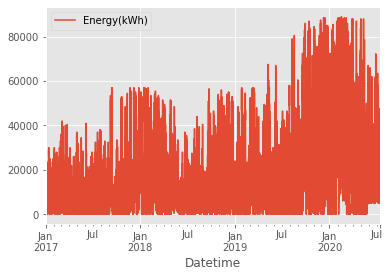

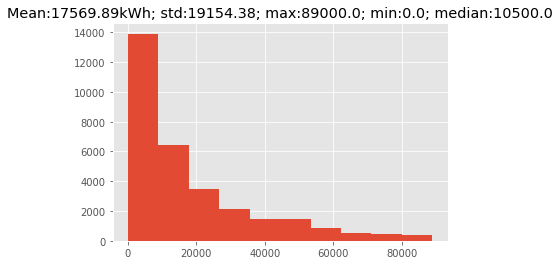

In [16]:
t = datetime.datetime.utcnow()
print('UTC time now: {}-{:02d}-{:02d} {:02d}:{:02d}:{:02d}\n'.format(t.year,t.month,t.day, t.hour,t.minute,t.second))
datautils.download_energy_latest()
df = datautils.read_ai4impact_energy('datasets/energy-ile-de-france.csv')
print(df.tail())
df.plot()
plt.show()

plt.hist(df.values)
x= df.values
plt.title(f'Mean:{x.mean():.2f}kWh; std:{x.std():.2f}; max:{x.max()}; min:{x.min()}; median:{np.median(x)}');
plt.show()

#### Downloading and Reading Raw RTE (+ real-time data from RTE)

Downloading
"eCO2mix_RTE_Ile-de-France_En-cours-TR.zip" from
`https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip`

Extracting: datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip
eCO2mix_RTE_Ile-de-France_En-cours-TR.xls --> as "datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.xls"
- - - - - 
File Name                                             Modified             Size
eCO2mix_RTE_Ile-de-France_En-cours-TR.xls      2020-07-15 10:31:20       982113
- - - - - 
Deleting
datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip

UTC time now: 2020-07-15 09:24:06

Latest timestamp for wind energy:
2020-07-15 08:00:00
                     Energy(kWh)
Datetime                        
2020-07-15 04:00:00      10000.0
2020-07-15 05:00:00       9500.0
2020-07-15 06:00:00      12250.0
2020-07-15 07:00:00      10750.0
2020-07-15 08:00:00       8000.0


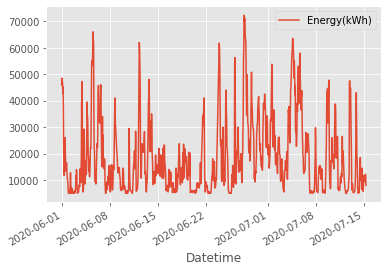

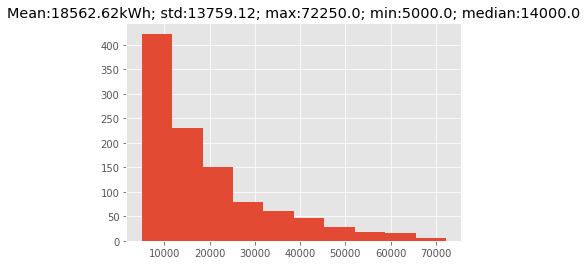

In [17]:
RTE_data_name = 'real_time'
RTE_file_path = datautils.download_raw_from_RTE(RTE_data_name,return_filelist=True)

# RTE_file_names = {"2017":"eCO2mix_RTE_Ile-de-France_Annuel-Definitif_2017.xls",
#               "2018":"eCO2mix_RTE_Ile-de-France_Annuel-Definitif_2018.xls",
#               "2019_May2020":"eCO2mix_RTE_Ile-de-France_En-cours-Consolide_FIXED_ERRCOLS.xls",
#               "real_time":"eCO2mix_RTE_Ile-de-France_En-cours-TR.xls"}
# file location: os.path.join(data_path,RTE_file_name0)


df=datautils.read_RTE_as_kwh(RTE_file_path[0],convert2UTC=True)
t = datetime.datetime.utcnow()
print('UTC time now: {}-{:02d}-{:02d} {:02d}:{:02d}:{:02d}\n'.format(t.year,t.month,t.day, t.hour,t.minute,t.second))
print(f'Latest timestamp for wind energy:\n{df.index[-1]}')
print(df.tail())
df.plot()
plt.show()

plt.hist(df.values)
x= df.values
plt.title(f'Mean:{x.mean():.2f}kWh; std:{x.std():.2f}; max:{x.max()}; min:{x.min()}; median:{np.median(x)}');
plt.show()

In [ ]:
# from datetime import datetime
# # unix time in ms to human-readable time format:
# datetime.utcfromtimestamp(1483232400000//1000).strftime('%Y-%m-%d %H:%M:%S')

### Wind Forecasts Data
Wind forecasts data for locations of major 8 wind farms in Ile-de-France are provided by [Terra Weather](http://www.terra-weather.com).
- Available data : __from 01 Jan 2017 to the present__ 
- UTC time zone
- Wind data come from _2 models_ , thus there are `2x8=16` forecasts in total.
- 2 var-s: `[` wind speed (m/s), direction (deg-N)`]`
    - wind dir-s are "from", e.g. 45 deg means wind is blowing _from_ the NE.
- **Real-time forecasts** are updated 4x daily (*every 6 hours*):
    - **from latest-update-to-(+10 days, same time)**
    - 2 models can have different update frequencies, and forecast lengths
    - Probably need to interpolate, fuse and take mean of the forecasts
- Historical forecats or "analysis" winds: our best guess from observations.
    - from 1/1/2017-
- Need to **interpolate** (linear interpolation) to hourly basis _each forecast file_.

In [18]:
# wind farm locations
print(datautils.locations)
# angerville-2 is "Les Pointes" wind farm

['guitrancourt', 'lieusaint', 'lvs-pussay', 'parc-du-gatinais', 'arville', 'boissy-la-riviere', 'angerville-1', 'angerville-2']


- **Download Wind Forecasts** (Need to Download ~6-hourly):
    - to download **both latest and historical** use `datautils.download_forecasts_all()`
    - to download **only latest** use `datautils.download_forecasts_latest()`

In [19]:
print(f'Downloading all forecats for \n{datautils.locations}')
datautils.download_forecasts_all()
# # to download just the latest forecasts use: `download_forecasts_latest()`
# datautils.download_forecasts_latest()

['guitrancourt', 'lieusaint', 'lvs-pussay', 'parc-du-gatinais', 'arville', 'boissy-la-riviere', 'angerville-1', 'angerville-2']
Latest wind forecasts:
Downloaded latest forecasts from
`https://ai4impact.org/P003/`
saved to
datasets

Historical wind forecasts:
Downloaded historical forecasts from
`https://ai4impact.org/P003/historical/`
saved to
datasets



- to print **names of the wind farm locations** use `datautils.locations` (list of names as `str`'s)
- for a location `[name]`:
    - **model 1 forecasts**:
        - **latest**--> `datasets/model1/[name].csv`
        - **hist-l**--> `datasets/historical1/[name].csv`
    - **model 2 forecasts** (names end with `*-b.csv`):
        - **latest**--> `datasets/model2/[name]-b.csv`
        - **hist-l**--> `datasets/historical2/[name]-b.csv`

In [20]:
data_path = os.path.relpath('datasets/model1/')
file_name = datautils.locations[0]+'.csv'

print(f'Loading\n{os.path.join(data_path,file_name)}')
df = datautils.read_forecast(os.path.join(data_path,file_name))

# df[df.index>=pd.to_datetime('10 Jul 2020')]
df

Loading
datasets/model1/guitrancourt.csv


,Speed(m/s),Direction (deg N)
Datetime,,
2020-07-15 00:00:00,1.56,320
2020-07-15 03:00:00,1.82,297
2020-07-15 06:00:00,2.46,281
2020-07-15 09:00:00,2.76,292
2020-07-15 12:00:00,3.00,324
...,...,...
2020-07-24 12:00:00,1.64,352
2020-07-24 15:00:00,2.64,16
2020-07-24 18:00:00,3.60,8


In [21]:
data_path = os.path.relpath('datasets/model2/')
file_name = datautils.locations[0]+'-b.csv'

print(f'Loading\n{os.path.join(data_path,file_name)}')
df = datautils.read_forecast(os.path.join(data_path,file_name))

# df[df.index>=pd.to_datetime('10 Jul 2020')]
df

Loading
datasets/model2/guitrancourt-b.csv


,Speed(m/s),Direction (deg N)
Datetime,,
2020-07-15 00:00:00,1.68,294
2020-07-15 03:00:00,3.30,285
2020-07-15 06:00:00,3.25,272
2020-07-15 09:00:00,4.30,290
2020-07-15 12:00:00,5.85,300
2020-07-15 15:00:00,5.17,308
2020-07-15 18:00:00,4.32,321
2020-07-15 21:00:00,3.52,305
2020-07-16 00:00:00,3.29,279


- Joining multiple forecasts

In [22]:
name_k = 0
dfs = []
models = ['model1','model2']
for farm in datautils.locations:
    for m in models:
        file_end = '.csv' if m==models[0] else '-b.csv'
        m_name = '_m1_' if m==models[0] else '_m2_'
        df = datautils.read_forecast( os.path.join( './datasets/', m, farm + file_end))
        df.rename(columns={'Speed(m/s)':farm+m_name+'speed','Direction (deg N)':farm+m_name+'dir'},
                  inplace=True)
        dfs.append(df)
# concatenate along axis 1 using datetime as reference
dfs = pd.concat(dfs,axis=1)

# method 1: use nearest neighbour (+ reindex for 1H freq)
# reindex part is not needed when joining with RTE power data with freq=1H
dfs = dfs.reindex(pd.date_range(dfs.index[0],dfs.index[-1],freq='H')).interpolate(method='nearest')

# method 2: use linear interpolation (for 1H freq)
# dfs = dfs.reindex(pd.date_range(dfs.index[0],dfs.index[-1],freq='H')).interpolate(method='linear')

# method 1b and 2b: use the methods above to get 1H freq, and then average for two models:
# ("speed1"*[cos(dir1), sin(dir1)] + "speed2"*[cos(dir2), sin(dir2)] )/2
# averaging vectors: need to use vector addition and then divide by 2.

In [24]:
dfs.head()

,guitrancourt_m1_speed,guitrancourt_m1_dir,guitrancourt_m2_speed,guitrancourt_m2_dir,lieusaint_m1_speed,lieusaint_m1_dir,lieusaint_m2_speed,lieusaint_m2_dir,lvs-pussay_m1_speed,lvs-pussay_m1_dir,...,boissy-la-riviere_m2_speed,boissy-la-riviere_m2_dir,angerville-1_m1_speed,angerville-1_m1_dir,angerville-1_m2_speed,angerville-1_m2_dir,angerville-2_m1_speed,angerville-2_m1_dir,angerville-2_m2_speed,angerville-2_m2_dir
2020-07-15 00:00:00,1.56,320.0,1.68,294.0,1.31,14.0,1.93,356.0,2.85,333.0,...,2.26,354.0,2.72,334.0,2.37,355.0,2.72,334.0,2.37,355.0
2020-07-15 01:00:00,1.56,320.0,1.68,294.0,1.31,14.0,1.93,356.0,2.85,333.0,...,2.26,354.0,2.72,334.0,2.37,355.0,2.72,334.0,2.37,355.0
2020-07-15 02:00:00,1.82,297.0,3.30,285.0,0.78,345.0,2.34,315.0,2.80,326.0,...,2.65,324.0,2.64,327.0,2.68,326.0,2.63,327.0,2.68,326.0
2020-07-15 03:00:00,1.82,297.0,3.30,285.0,0.78,345.0,2.34,315.0,2.80,326.0,...,2.65,324.0,2.64,327.0,2.68,326.0,2.63,327.0,2.68,326.0
2020-07-15 04:00:00,1.82,297.0,3.30,285.0,0.78,345.0,2.34,315.0,2.80,326.0,...,2.65,324.0,2.64,327.0,2.68,326.0,2.63,327.0,2.68,326.0


## Trader

In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Uncomment below for **for 1/1/2020- now** wind energy:

UTC time now: 2020-07-15 09:53:36

Downloaded from:
`https://ai4impact.org/P003/historical/energy-ile-de-france.csv`
saved to:
datasets/energy-ile-de-france.csv
                     Energy(kWh)
Datetime                        
2020-07-15 04:00:00      10000.0
2020-07-15 05:00:00       9500.0
2020-07-15 06:00:00      12250.0
2020-07-15 07:00:00      10750.0
2020-07-15 08:00:00       8000.0


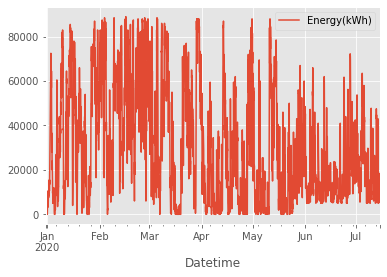

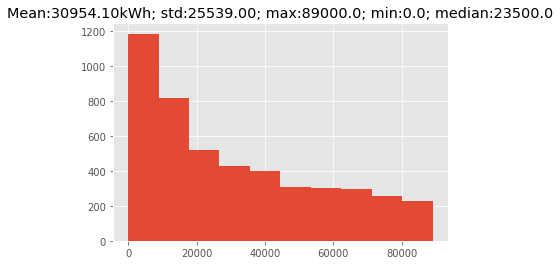

In [76]:
t = datetime.datetime.utcnow()
print('UTC time now: {}-{:02d}-{:02d} {:02d}:{:02d}:{:02d}\n'.format(t.year,t.month,t.day, t.hour,t.minute,t.second))
datautils.download_energy_latest() # updates readings
df = datautils.read_ai4impact_energy('datasets/energy-ile-de-france.csv')

# Select 2020 data
df = df[df.index>pd.to_datetime('31/12/2019')]

print(df.tail())
df.plot()
plt.show()

plt.hist(df.values)
x= df.values
plt.title(f'Mean:{x.mean():.2f}kWh; std:{x.std():.2f}; max:{x.max()}; min:{x.min()}; median:{np.median(x)}');
plt.show()

Uncomment below for **for 1/6/2020- now** wind energy:

Downloading
"eCO2mix_RTE_Ile-de-France_En-cours-TR.zip" from
`https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip`

Extracting: datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip
eCO2mix_RTE_Ile-de-France_En-cours-TR.xls --> as "datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.xls"
- - - - - 
File Name                                             Modified             Size
eCO2mix_RTE_Ile-de-France_En-cours-TR.xls      2020-07-15 10:31:20       982113
- - - - - 
Deleting
datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip

UTC time now: 2020-07-15 09:25:48

Latest timestamp for wind energy:
2020-07-15 08:00:00
                     Energy(kWh)
Datetime                        
2020-07-15 04:00:00      10000.0
2020-07-15 05:00:00       9500.0
2020-07-15 06:00:00      12250.0
2020-07-15 07:00:00      10750.0
2020-07-15 08:00:00       8000.0


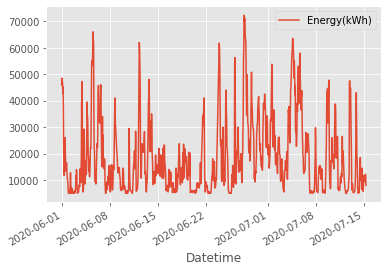

In [28]:
RTE_data_name = 'real_time'
RTE_file_path = datautils.download_raw_from_RTE(RTE_data_name,return_filelist=True)

# RTE_file_names = {"2017":"eCO2mix_RTE_Ile-de-France_Annuel-Definitif_2017.xls",
#               "2018":"eCO2mix_RTE_Ile-de-France_Annuel-Definitif_2018.xls",
#               "2019_May2020":"eCO2mix_RTE_Ile-de-France_En-cours-Consolide_FIXED_ERRCOLS.xls",
#               "real_time":"eCO2mix_RTE_Ile-de-France_En-cours-TR.xls"}
# file location: os.path.join(data_path,RTE_file_name0)


df=datautils.read_RTE_as_kwh(RTE_file_path[0],convert2UTC=True)
t = datetime.datetime.utcnow()
print('UTC time now: {}-{:02d}-{:02d} {:02d}:{:02d}:{:02d}\n'.format(t.year,t.month,t.day, t.hour,t.minute,t.second))
print(f'Latest timestamp for wind energy:\n{df.index[-1]}')
print(df.tail())
df.plot()
plt.show()

In [78]:
from trader import trader_simulation
# These are defaults for  trader.trader_simulation()
INITIAL_CASH = 10000000 # euro cents, starting capital
SALE_PRICE = 10 # euro cents/kWh
SPOT_PRICE = 20 # euro cents/kWh
PENALTY_PRICE = 100 # euro cents/kWh

In [79]:
trading_hours = df.index
print(f'Trading hours (total):{len(trading_hours)}, [start:{str(trading_hours[0])} ---> end:{str(trading_hours[-1])}]')
print(f'dT (frequency):{str(trading_hours[1]-trading_hours[0])}')

Trading hours (total):4736, [start:2019-12-31 01:00:00 ---> end:2020-07-15 08:00:00]
dT (frequency):0 days 01:00:00


**Maximum profit possible** :defined as perfect prediction

In [88]:
Y_targ = df['Energy(kWh)'][np.logical_not(df['Energy(kWh)'].isna())].values
trading_hours = df[np.logical_not(df['Energy(kWh)'].isna())].index
print(f'Perfect trading Ytarget==Yprediction (error=0):{trader_simulation(trading_hours,Y_targ,Y_targ)/1000:.3f}k')

Perfect trading Ytarget==Yprediction (error=0):1465986.250k


Random trader, using Exponential distribution

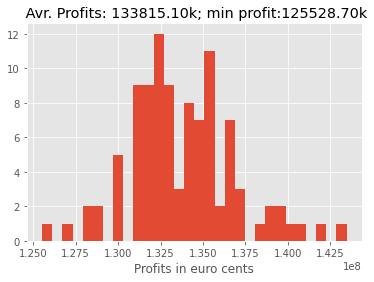

In [82]:
# real values
Y_targ = df['Energy(kWh)'][np.logical_not(df['Energy(kWh)'].isna())].values
trading_hours = df[np.logical_not(df['Energy(kWh)'].isna())].index

profits = []
for k in range(100):
    # here I set a limit 50000 to our random prediction
    Y_pred = np.minimum(17000,np.random.exponential(
        scale=5000,size=(len(trading_hours),))) # random predictions in kWh scale [0...80000]
    profits.append(trader_simulation(trading_hours,Y_pred,Y_targ))
plt.hist(profits,bins=30)
plt.xlabel('Profits in euro cents')
plt.title(f' Avr. Profits: {(np.mean(profits))/1000:.2f}k; min profit:{(np.min(profits))/1000:.2f}k');

Random Uniform Distribution Trader:

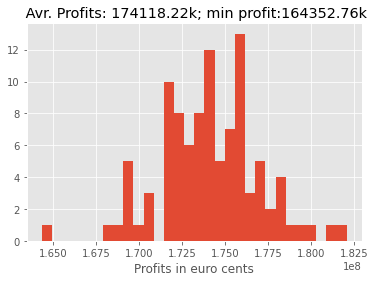

In [83]:
# real values
Y_targ = df['Energy(kWh)'][np.logical_not(df['Energy(kWh)'].isna())].values
trading_hours = df[np.logical_not(df['Energy(kWh)'].isna())].index

profits = []
for k in range(100):
    # here I set a limit 50000 to our random prediction
    Y_pred = 12000*np.random.rand(len(trading_hours)) # random predictions in kWh scale [0...80000]
    profits.append(trader_simulation(trading_hours,Y_pred,Y_targ))
plt.hist(profits,bins=30)
plt.xlabel('Profits in euro cents')
plt.title(f' Avr. Profits: {(np.mean(profits))/1000:.2f}k; min profit:{(np.min(profits))/1000:.2f}k');

Constant trader, predictions are constant

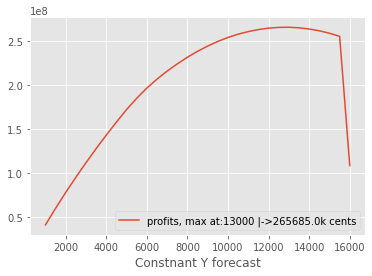

In [96]:
# real values
Y_targ = df['Energy(kWh)'][np.logical_not(df['Energy(kWh)'].isna())].values
trading_hours = df[np.logical_not(df['Energy(kWh)'].isna())].index

Y_preds = np.arange(1000,16500,500)
profits = np.zeros_like(Y_preds)

for k,y_const in enumerate(Y_preds):
    # here I set a limit 50000 to our random prediction
    Y_pred =y_const*np.ones_like(Y_targ) # constant in kWh scale [0...80000]
    profits[k]=trader_simulation(trading_hours,Y_pred,Y_targ) # set debug=True to see hourly records
#     print(f'y={y_const} Profits: {(np.mean(profits[k]))/1000:.0f}k cents;')

plt.plot(Y_preds,profits,label=f'profits, max at:{Y_preds[np.argmax(profits)]} |->{np.max(profits)/1000:.1f}k cents')
plt.legend()
plt.xlabel('Constnant Y forecast');

## Notes on Deployment

In [ ]:
# round to minutes/hours/ etc.:
# pd.to_datetime('now').round('min')
# extract current hour/minute/second/:
# pd.to_datetime('now').second
# ---
# PAUSE EXAMPLE:
# Do sth everyday at 2AM:
# import time
# import datetime

# # if for some reason this script is still running
# # after a year, we'll stop after 365 days
# for i in xrange(0,365):
#     # sleep until 2AM
#     t = datetime.datetime.today()
#     future = datetime.datetime(t.year,t.month,t.day,2,0)
#     if t.hour >= 2:
#         future += datetime.timedelta(days=1)
#     time.sleep((future-t).seconds) # or use total_seconds() if the duration is longer than one day

#     # do 2AM stuff

# CURRENT TIME:
# import time
# import datetime
# t = datetime.datetime.today()
# print('Current time:\n{}/{}/{} {}:{}:{}'.format(t.day,t.month,t.year, t.hour,t.minute,t.second))
# t = datetime.datetime.utcnow()
# print('UTC time:\n{}/{}/{} {}:{}:{}'.format(t.day,t.month,t.year, t.hour,t.minute,t.second))